In [2]:
import talib
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
df = yf.download(tickers='BTC-USD')
df.drop("Adj Close", axis=1, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Stratégie
df["RSI"] = talib.RSI(df.Close)
df["In"] = (
    (df.RSI.shift(1) < 30) &
    (30 < df.RSI)
)
df["Out"] = (
    (df.RSI.shift(1) < 70) &
    (70 < df.RSI)
)
df["Size"] = 1

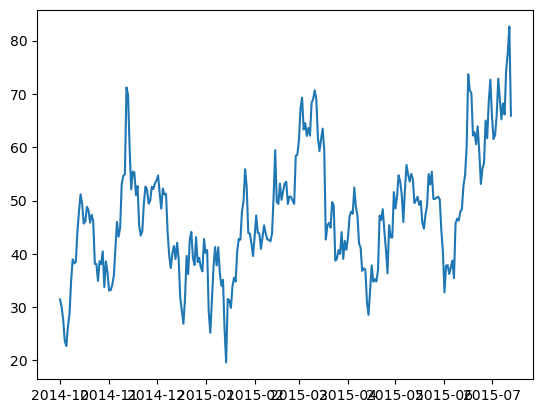

In [6]:
plt.plot(df.RSI[:300])

In [143]:
# Traitement
commission = 0.06/100

df["dateOut"] = df.apply(
    lambda x: (
        df
        .Out[x.name:]
        .idxmax()
    ),
    axis=1
)
df.loc[
    (df.index == df.dateOut) & np.logical_not(df.Out), 
    "dateOut"
] = np.nan # retrait des 
df["gain"] = (
    df
    .apply(
        lambda x: 
        df.loc[x.dateOut, "Close"] / x.Close - commission 
        if x.In 
        else 1,
        axis=1
    )
)
df["gainCum"] = df.gain.cumprod()
df["market"] = (
    df
    .Close
    .rolling(366)
    .apply(lambda x: x[-1]/x[0]-1)
)
# effective size
df["effSize"] = 0
df.loc[df.In, "effSize"] = df.Size[df.In]

df["Statut"] = "Standby"
df.loc[df.gain > 1, "Statut"] = "Gagnant"
df.loc[df.gain < 1, "Statut"] = "Perdant"

In [127]:
df.gain.cumprod()

Date
2014-09-17     1.000000
2014-09-18     1.000000
2014-09-19     1.000000
2014-09-20     1.000000
2014-09-21     1.000000
                ...    
2023-06-14    46.172506
2023-06-15    46.172506
2023-06-16    46.172506
2023-06-17    46.172506
2023-06-18    46.172506
Name: gain, Length: 3197, dtype: float64

In [110]:
df.rolling(2).apply(lambda x: 1 if x[-1].Out else x)

Rolling [window=2,center=False,axis=0,method=single]

In [125]:
sum(df.effSize == 1)

43

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2023-06-09', '2023-06-10', '2023-06-11', '2023-06-12',
               '2023-06-13', '2023-06-14', '2023-06-15', '2023-06-16',
               '2023-06-17', '2023-06-18'],
              dtype='datetime64[ns]', name='Date', length=3197, freq=None)

In [134]:

import plotly.express as px
help(px.line)

Help on function line in module plotly.express._chart_types:

line(data_frame=None, x=None, y=None, line_group=None, color=None, line_dash=None, symbol=None, hover_name=None, hover_data=None, custom_data=None, text=None, facet_row=None, facet_col=None, facet_col_wrap=0, facet_row_spacing=None, facet_col_spacing=None, error_x=None, error_x_minus=None, error_y=None, error_y_minus=None, animation_frame=None, animation_group=None, category_orders=None, labels=None, orientation=None, color_discrete_sequence=None, color_discrete_map=None, line_dash_sequence=None, line_dash_map=None, symbol_sequence=None, symbol_map=None, markers=False, log_x=False, log_y=False, range_x=None, range_y=None, line_shape=None, render_mode='auto', title=None, template=None, width=None, height=None) -> plotly.graph_objs._figure.Figure
        In a 2D line plot, each row of `data_frame` is represented as vertex of
        a polyline mark in 2D space.
        
    Parameters
    ----------
    data_frame: DataFrame o

In [144]:
import plotly.graph_objects as go

import plotly.express as px


fig = go.Figure()
fig.add_trace(go.Candlestick(x=df.index, open=df.Open, high=df.High, low=df.Low, close=df.Close))
fig.add_trace(px.line(x=df.index, y=df.dcO))

# st.plotly_chart(fig)

AttributeError: 'DataFrame' object has no attribute 'dcO'

In [150]:
df["Statut"] = "Standby"
df.loc[df.gain > 1, "Statut"] = "Gagnant"
df.loc[df.gain < 1, "Statut"] = "Perdant"
df

,Open,High,Low,Close,Volume,RSI,In,Out,Size,dateOut,gain,gainCum,market,effSize,Statut
Date,,,,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,NaN,False,False,1,2014-11-12,1.0,1.000000,NaN,0,Standby
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,NaN,False,False,1,2014-11-12,1.0,1.000000,NaN,0,Standby
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,NaN,False,False,1,2014-11-12,1.0,1.000000,NaN,0,Standby
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,NaN,False,False,1,2014-11-12,1.0,1.000000,NaN,0,Standby
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,NaN,False,False,1,2014-11-12,1.0,1.000000,NaN,0,Standby
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-14,25920.257812,26041.800781,24902.152344,25124.675781,14265717766,35.993391,False,False,1,NaT,1.0,46.172506,0.131396,0,Standby
2023-06-15,25121.673828,25735.308594,24797.167969,25576.394531,15837384409,40.909351,False,False,1,NaT,1.0,46.172506,0.133061,0,Standby
2023-06-16,25575.283203,26463.173828,25245.357422,26327.462891,16324646965,48.053288,False,False,1,NaT,1.0,46.172506,0.291724,0,Standby


In [157]:


Strategy = {
    "RSI": "tets"
}

In [159]:
Strategy.keys()

dict_keys(['RSI'])

In [55]:
datetime("2014-11-12")

TypeError: 'str' object cannot be interpreted as an integer

In [56]:
help(datetime)

Help on class datetime in module datetime:

class datetime(date)
 |  datetime(year, month, day[, hour[, minute[, second[, microsecond[,tzinfo]]]]])
 |  
 |  The year, month and day arguments are required. tzinfo may be None, or an
 |  instance of a tzinfo subclass. The remaining arguments may be ints.
 |  
 |  Method resolution order:
 |      datetime
 |      date
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 |  __le__(self, value, /)
 |      Return self<=value.
 |  
 |  __lt__(self, value, /)
 |      Return self<value.
 |  
 |  __ne__(self, value, /)
 |      Return self!=value.
 |  
 |  __radd__(self, value

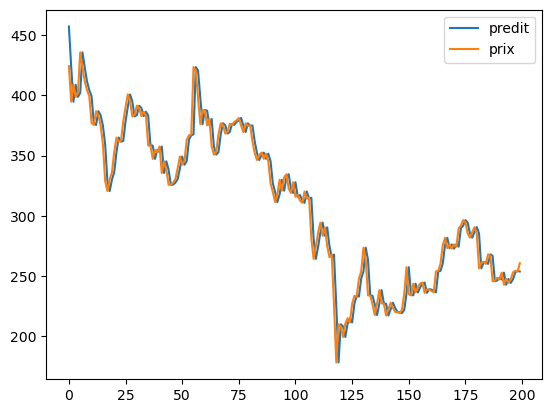

In [171]:
plt.plot(df.Close.to_list()[0:200], label="predit")
plt.plot(df.Close.to_list()[1:201], label="prix")
plt.legend()